In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class ExactGPModel(gpytorch.GPModel):
    def __init__(self):
        super(ExactGPModel,self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)

model = ExactGPModel()
model.condition(train_x, train_y)

ExactGPModel (
  (likelihood): GaussianLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (covar_module): RBFKernel (
  )
)

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

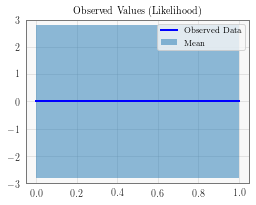

In [6]:
fig = plot_model_and_predictions(model, plot_train_data=False)

In [7]:
# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
    ))
    optimizer.step()
    
# Set back to eval mode
model.eval()
None

Iter 1/20 - Loss: 15.584   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/20 - Loss: 13.038   log_lengthscale: -0.100   log_noise: -0.100
Iter 3/20 - Loss: 12.977   log_lengthscale: -0.199   log_noise: -0.200
Iter 4/20 - Loss: 13.258   log_lengthscale: -0.299   log_noise: -0.300
Iter 5/20 - Loss: 12.073   log_lengthscale: -0.399   log_noise: -0.399
Iter 6/20 - Loss: 12.211   log_lengthscale: -0.499   log_noise: -0.499
Iter 7/20 - Loss: 11.517   log_lengthscale: -0.600   log_noise: -0.598
Iter 8/20 - Loss: 11.017   log_lengthscale: -0.700   log_noise: -0.695
Iter 9/20 - Loss: 11.018   log_lengthscale: -0.801   log_noise: -0.791
Iter 10/20 - Loss: 10.493   log_lengthscale: -0.903   log_noise: -0.887
Iter 11/20 - Loss: 9.655   log_lengthscale: -1.006   log_noise: -0.982
Iter 12/20 - Loss: 10.570   log_lengthscale: -1.111   log_noise: -1.076
Iter 13/20 - Loss: 9.263   log_lengthscale: -1.216   log_noise: -1.171
Iter 14/20 - Loss: 9.440   log_lengthscale: -1.322   log_noise: -1.266
Iter 1

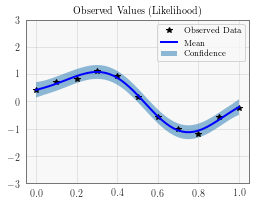

In [8]:
fig = plot_model_and_predictions(model)